### Synthetic Minority Oversampling Technique

A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.

One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model.

A general downside of the approach is that synthetic examples are created without considering the majority class, possibly resulting in ambiguous examples if there is a strong overlap for the classes.

[source](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [3]:
#pip install imbalanced-learn
import imblearn
print(imblearn.__version__)

0.7.0


Counter({0: 9900, 1: 100})


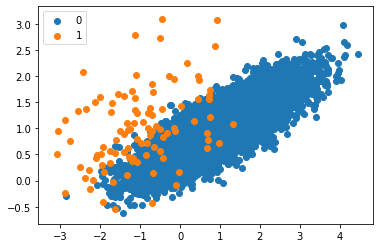

In [8]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

counter = Counter(y)
print(counter)
# now that is imbalance!

for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix,1], label=str(label))
    
plt.legend()
plt.show()

**Time to oversample**

In [10]:
from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y)
print(counter) # wow check that out

Counter({0: 9900, 1: 9900})


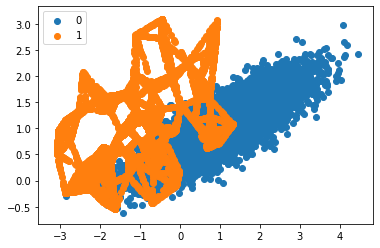

In [12]:
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

**Combine under and over sampling, how cool!**

The imbalanced-learn library supports random undersampling via the *RandomUnderSampler class*.

We can update the example to first oversample the minority class to have 10 percent the number of examples of the majority class (e.g. about 1,000), then use random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class (e.g. about 2,000).

To implement this, we can specify the desired ratios as arguments to the SMOTE and RandomUnderSampler classes; for example:

Counter({0: 1980, 1: 990})


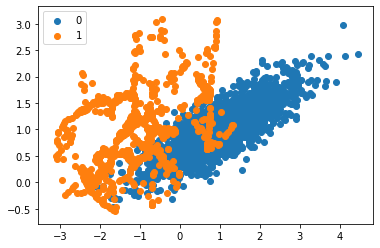

In [16]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# transform the dataset
X, y = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

### Classification

Use repeated stratified k-fold cross-validation to evaluate the model. We will use three repeats of 10-fold cross-validation, meaning that 10-fold cross-validation is applied three times fitting and evaluating 30 models on the dataset.

The dataset is stratified, meaning that each fold of the cross-validation split will have the same class distribution as the original dataset, in this case, a 1:100 ratio. We will evaluate the model using the ROC area under curve (AUC) metric. This can be optimistic for severely imbalanced datasets but will still show a relative change with better performing models

In [21]:
# first attempt, no transformation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# define model
model = DecisionTreeClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.766


In [23]:
# now try SMOTE
# define pipeline
steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.819


> it is believed that SMOTE performs better when combined with undersampling of the majority class, such as random undersampling.

In [24]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# define pipeline
model = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.848
